In [1]:
import torch
import my_nlp_library as nlp
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# Load the GloVe vectors
def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_vectors[word] = vector
    return glove_vectors

glove_file = "glove.6B/glove.6B.300d.txt"  # Change this to the appropriate file if needed
glove_vectors = load_glove_vectors(glove_file)


def get_vocabulary_from_glove(glove_vectors):
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for word, vector in glove_vectors.items():
        vocab[word] = len(inverse_vocab)
        inverse_vocab.append(word)
    return vocab, inverse_vocab

vocab, inverse_vocab = get_vocabulary_from_glove(glove_vectors)

In [3]:
embedding_dim = 300  # This should match the dimension of the GloVe vectors
vocab_size = len(glove_vectors) + 2
embedding = nn.Embedding(vocab_size, embedding_dim)

for idx, word in enumerate(inverse_vocab[2:]):
    i = idx + 2
    embedding.weight[idx].data = glove_vectors[word]

print("Embedding layer created with shape:", embedding.weight.shape)

Embedding layer created with shape: torch.Size([400002, 300])


In [4]:
embedding_2000 = embedding.weight.data[:2000]  # estou pegando somente as primeiras 1000 palavras

X = embedding_2000.numpy()

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)



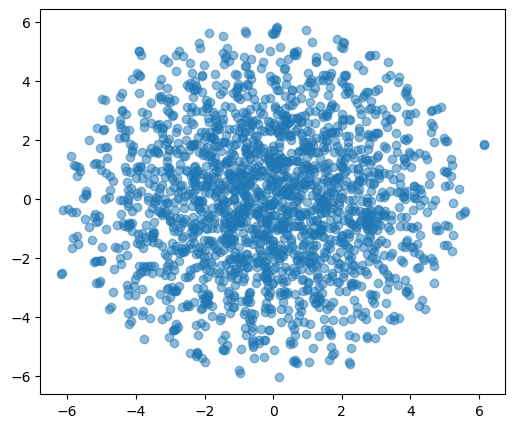

In [5]:
plt.figure(figsize=(6, 5))
vocab_to_plot = 2000
plt.scatter(X_2d[:vocab_to_plot, 0], X_2d[:vocab_to_plot, 1], alpha=0.5)

C:\Users\rodri\AppData\Local\Temp\ipykernel_8404\3340880089.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  embeddings = torch.tensor(embeddings)


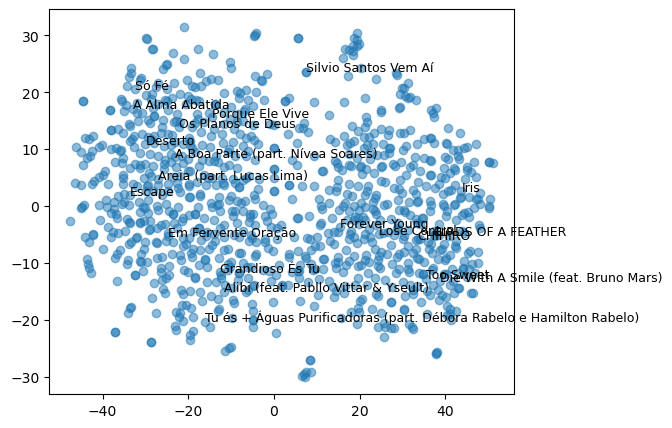

In [6]:
import re

def get_vocabulary(text : str,
                   expr: str=r"\b\w+\b",
                   case_sensitive : bool=False,
                   ) -> dict:
    if case_sensitive == False:
        text = text.lower()  
    vocabulary = set(re.findall(expr, text))
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for i, token in enumerate(vocabulary):
        if token not in vocab:
            vocab[token] = i+2 # We start from 2 because 0 and 1 are reserved for <UNK> and <PAD>
            inverse_vocab.append(token)
    return vocab, inverse_vocab

def tokenize_words(text : str,
             vocab : dict,
             expr : str= r"\b\w+\b",
             sentence_length : int = 10,
             case_sensitive : bool = False) -> list:
    if case_sensitive == False:
        text = text.lower()
    words = re.findall(expr, text)
    tokens = []
    for i, w in enumerate(words):
        if i == sentence_length:
            break
        if w in vocab:
            tokens.append(vocab[w])
        else:
            tokens.append(vocab["<UNK>"])


    if len(tokens) < sentence_length:
        n_pad = sentence_length - len(tokens)
        pad = [vocab["<PAD>"]] * n_pad
        tokens = pad + tokens
    return tokens

def detokenize_words(tokens : list,
                    invert_vocab : list) -> str:
    text = " ".join([invert_vocab[token] for token in tokens])
    return text    

class MyTokenizer:
    def __init__(self, sentence_length, case_sensitive=False, vocab=None, inverse_vocab=None):
        self.sentence_length = sentence_length
        self.case_sensitive = case_sensitive
        self.vocab = vocab
        self.inverse_vocab = inverse_vocab
        if vocab is not None:
            self.vocab_size = len(vocab)

    def fit(self, phrases : list, expr : str=r"\b\w+\b"):
        self.vocab, self.inverse_vocab = get_vocabulary(" ".join(phrases),
                                                        expr=expr,
                                                        case_sensitive=self.case_sensitive)
        self.vocab_size = len(self.vocab)
        
    def __call__(self, x):
        return tokenize_words(x,
                              self.vocab,
                              sentence_length=self.sentence_length,
                              case_sensitive=self.case_sensitive)
    



df = pd.read_csv('data/musicas.csv', delimiter='|')

'''
| Titulo-Artista | Letra |
| Die With A Smile (feat. Bruno Mars)-Lady Gaga |	Ooh\nI I just woke up from a dream\nWhere you... |
| ... | ... |
'''

# vamos tokenizar as letras com nlp.tokenize_words e depois vamos pegar os embeddings de cada palavra

# tokenizar as letras
tokenizer = MyTokenizer(sentence_length=10, case_sensitive=False, vocab=None, inverse_vocab=None)
tokenizer.fit(df['Letra'])
df['Tokens'] = df['Letra'].apply(tokenizer)

# pegar os embeddings de cada palavra
embeddings = []
for tokens in df['Tokens']:
    embeddings.append(embedding(torch.tensor(tokens)).mean(dim=0).detach().numpy())
    
embeddings = torch.tensor(embeddings)

# vamos fazer o tsne
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5)

# vamos fazer escrever no grafico o nome de algumas musicas
n = 20

for i in range(n):
    plt.text(X_2d[i, 0], X_2d[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)
    
plt.show()


Podemos perceber 2 grupos no gráfico do tsne. Isso se dá por conta das duas línguas presentes no dataset, inglês e português. Quando um plt.text é feito, fica muito clara a separação entre as duas línguas.

Epoch 0, Loss 0.15406659245491028
Epoch 100, Loss 0.06927517801523209
Epoch 200, Loss 0.057457052171230316
Epoch 300, Loss 0.054219361394643784
Epoch 400, Loss 0.053237706422805786
Epoch 500, Loss 0.052868857979774475
Epoch 600, Loss 0.052699003368616104
Epoch 700, Loss 0.05260816588997841
Epoch 800, Loss 0.05255602300167084
Epoch 900, Loss 0.05252520367503166


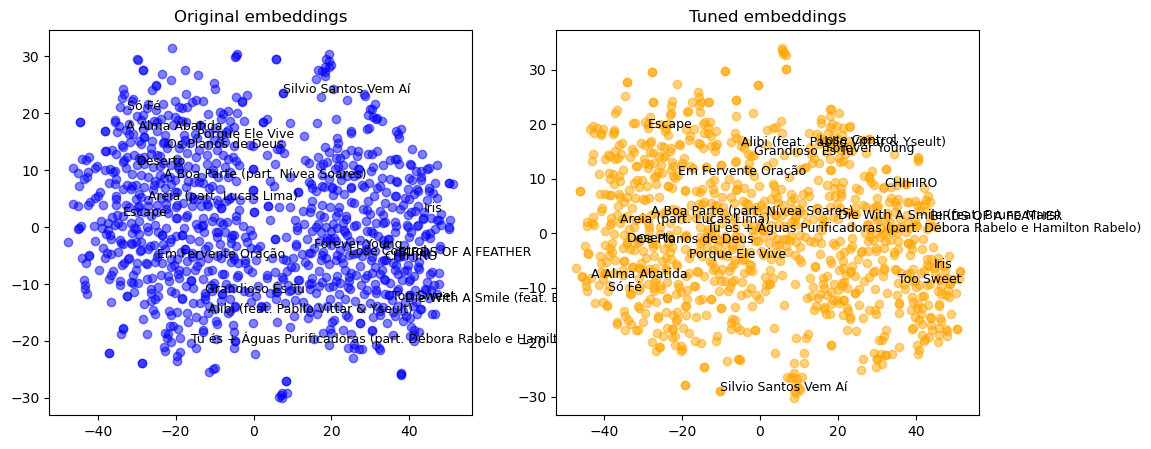

In [23]:

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        xenc = self.encoder(x)
        x = self.decoder(xenc)
        return x, xenc
    
input_size = embedding_dim
hidden_size = 50
autoencoder = Autoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

X = embeddings

n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output, _ = autoencoder(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        
_, encoded = autoencoder(X)
encoded = encoded.detach().numpy()

tsne = TSNE(n_components=2, random_state=0)
X_2d_tuned = tsne.fit_transform(encoded)

n = 20

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, color='blue')
plt.title("Original embeddings")

for i in range(n):
    plt.text(X_2d[i, 0], X_2d[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)

plt.subplot(1, 2, 2)
plt.scatter(X_2d_tuned[:, 0], X_2d_tuned[:, 1], alpha=0.5, color='orange')
plt.title("Tuned embeddings")

for i in range(n):
    plt.text(X_2d_tuned[i, 0], X_2d_tuned[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)

plt.show()

# analisando os gráficos:
# os embeddings originais parecem estar um pouco mais espalhados, enquanto os embeddings ajustados parecem estar mais clusterizados. Isso sugere que o autoencoder está 
# separando os embeddings em grupos mais coesos (nesse caso o idioma das músicas). Isso é um bom sinal, pois sugere que o autoencoder está aprendendo a representação
# das músicas de forma mais compacta e informativa.

In [8]:
# Inicialize o tokenizer e ajuste-o ao vocabulário das letras no df
tokenizer = MyTokenizer(sentence_length=10, case_sensitive=False)
tokenizer.fit(df['Letra'].tolist())

# Tokenize cada letra no DataFrame e armazene os tokens
df['Tokens'] = df['Letra'].apply(lambda x: tokenizer(x))


In [9]:
import torch

# Definindo a função que calcula o embedding médio
def get_average_embedding(tokens, embedding):
    # Converte tokens em embeddings e calcula a média
    embeddings = torch.stack([embedding(torch.tensor([token])) for token in tokens if token != tokenizer.vocab["<PAD>"]])
    return torch.mean(embeddings, dim=0) if embeddings.shape[0] > 0 else torch.zeros(embedding.embedding_dim)

# Aplica a função de embedding médio a cada letra
df['Embedding'] = df['Tokens'].apply(lambda tokens: get_average_embedding(tokens, embedding))


In [37]:
import json

def get_closest_song_tuned(lyrics, embedding, tokenizer, autoencoder, use_tuned=True, threshold=0.5, n=10):
    # Tokeniza e calcula o embedding médio da letra buscada
    tokens = tokenizer(lyrics)
    lyrics_embedding = get_average_embedding(tokens, embedding)
    
    if use_tuned:
        # Passar pelo autoencoder para obter o embedding tunado
        _, lyrics_embedding = autoencoder(lyrics_embedding.unsqueeze(0))
        lyrics_embedding = lyrics_embedding.squeeze(0)
    
    # Calcula a distância entre o embedding da letra e o embedding médio de cada letra no dataset
    distances = []
    for i, row_embedding in enumerate(df['Embedding']):
        if use_tuned:
            _, row_embedding = autoencoder(row_embedding.unsqueeze(0))
            row_embedding = row_embedding.squeeze(0)
        distance = torch.dist(lyrics_embedding, row_embedding).item()
        distances.append((i, distance))
    
    # Filtra as músicas que estão dentro do threshold e ordena pela menor distância
    within_threshold = [d for d in distances if d[1] <= threshold]
    closest = sorted(within_threshold, key=lambda x: x[1])[:n]
    
    # Retorna os títulos, letras e distâncias em um formato específico
    results = [
        {
            "title": df.iloc[c[0]]['Titulo-Artista'],
            "content": df.iloc[c[0]]['Letra'],
            "distance": c[1]
        }
        for c in closest
    ]
    
    # Formata o resultado em JSON com indentação
    print("Músicas encontradas:", len(results))
    print(json.dumps(results, indent=4, ensure_ascii=False))

In [38]:
# Testes da busca com threshold e visualização das distâncias
print("Teste com embeddings tunados:")
get_closest_song_tuned("Burning in your eyes", embedding, tokenizer, autoencoder, use_tuned=True, threshold=8)
print("\n")

print("Teste com embeddings não tunados:")
get_closest_song_tuned("Burning in your eyes", embedding, tokenizer, autoencoder, use_tuned=False, threshold=8)
print("\n")

Teste com embeddings tunados:
Músicas encontradas: 10
[
    {
        "title": "Video Games-Lana Del Rey",
        "content": "Swinging in the backyard\nPull up in your fast car\nWhistling my name\nOpen up a beer\nAnd you say: Get over here and play a video game I'm in his favorite sundress\nWatching me get undressed\nTake that body downtown\nI say: You the bestest, lean in for a big kiss\nPut his favorite perfume on\nGo play a video game It's you, it's you, it's all for you\nEverything I do\nI tell you all the time\nHeaven is a place on Earth with you\nTell me all the things you wanna do\nI heard that you like the bad girls, honey\nIs that true? It's better than I ever even knew\nThey say that the world was built for two\nOnly worth living if somebody is loving you\nAnd, baby, now, you do Singing in the old bars\nSwinging with the old stars\nLiving for the fame\nKissing in the blue dark\nPlaying pool and wild darts\nVideo games He holds me in his big arms\nDrunk and I am seeing stars\

In [49]:
print("Teste 1:")
get_closest_song_tuned("When the days are cold\nAnd the cards all fold\nAnd the saints we see\nAre all made of gold When your dreams all fail\nAnd the ones we hail", 
                       embedding, 
                       tokenizer, 
                       autoencoder, 
                       use_tuned=True, 
                       threshold=4)


Teste 1:
Músicas encontradas: 10
[
    {
        "title": "Demons-Imagine Dragons",
        "content": "When the days are cold\nAnd the cards all fold\nAnd the saints we see\nAre all made of gold When your dreams all fail\nAnd the ones we hail\nAre the worst of all\nAnd the blood's run stale I wanna hide the truth\nI wanna shelter you\nBut with the beast inside\nThere's nowhere we can hide No matter what we breed\nWe still are made of greed\nThis is my kingdom come\nThis is my kingdom come When you feel my heat\nLook into my eyes\nIt's where my demons hide\nIt's where my demons hide\nDon't get too close\nIt's dark inside\nIt's where my demons hide\nIt's where my demons hide At the curtain's call\nIs the last of all\nWhen the lights fade out\nAll the sinners crawl\nSo they dug your grave\nAnd the masquerade\nWill come calling out\nAt the mess you made Don't wanna let you down\nBut I am hell bound\nThough this is all for you\nDon't wanna hide the truth No matter what we breed\nWe still a

In [59]:
print("Teste 2:")
get_closest_song_tuned("Burnin in your eyes", 
                       embedding, 
                       tokenizer, 
                       autoencoder, 
                       use_tuned=True, 
                       threshold=4)


Teste 2:
Músicas encontradas: 7
[
    {
        "title": "Video Games-Lana Del Rey",
        "content": "Swinging in the backyard\nPull up in your fast car\nWhistling my name\nOpen up a beer\nAnd you say: Get over here and play a video game I'm in his favorite sundress\nWatching me get undressed\nTake that body downtown\nI say: You the bestest, lean in for a big kiss\nPut his favorite perfume on\nGo play a video game It's you, it's you, it's all for you\nEverything I do\nI tell you all the time\nHeaven is a place on Earth with you\nTell me all the things you wanna do\nI heard that you like the bad girls, honey\nIs that true? It's better than I ever even knew\nThey say that the world was built for two\nOnly worth living if somebody is loving you\nAnd, baby, now, you do Singing in the old bars\nSwinging with the old stars\nLiving for the fame\nKissing in the blue dark\nPlaying pool and wild darts\nVideo games He holds me in his big arms\nDrunk and I am seeing stars\nThis is all I think o

In [57]:
print("Teste 3:")

get_closest_song_tuned("When you try your best", 
                       embedding, 
                       tokenizer, 
                       autoencoder, 
                       use_tuned=True, 
                       threshold=4)

Teste 3:
Músicas encontradas: 10
[
    {
        "title": "Fix You-Coldplay",
        "content": "When you try your best, but you don't succeed\nWhen you get what you want, but not what you need\nWhen you feel so tired, but you can't sleep\nStuck in reverse And the tears come streaming down your face\nWhen you lose something you can't replace\nWhen you love someone, but it goes to waste\nCould it be worse? Lights will guide you home\nAnd ignite your bones\nAnd I will try to fix you And high up above or down below\nWhen you're too in love to let it go\nBut if you never try, you'll never know\nJust what you're worth Lights will guide you home\nAnd ignite your bones\nAnd I will try to fix you Tears stream down your face\nWhen you lose something you cannot replace\nTears stream down your face\nAnd I Tears stream down your face\nI promise you, I'll learn from my mistakes\nTears stream down your face\nAnd I Lights will guide you home\nAnd ignite your bones\nAnd I will try to fix you",
      